In [1]:
import numpy as np 
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


# 1. Local Outlier Factor
This first part of the assignment will consist of implementing the LOF from the ground up.

First, we need a dataset to work with, which is created below. 

In [2]:
data, labels = make_blobs(n_samples=[100, 100, 2],random_state=42)

## Task: Understand the dataset
1. Shortly describe the dataset, and what you would expect the LOF to be of the different datapoints

## Answer
- Write your answers here

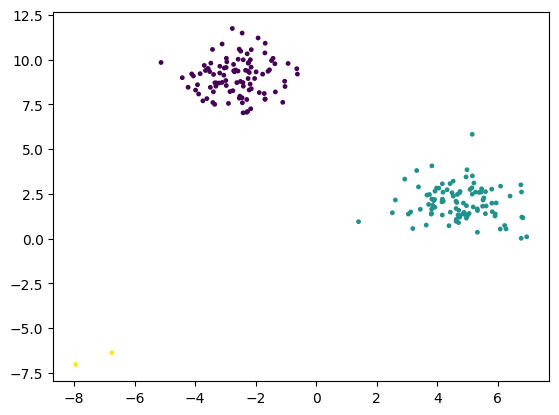

In [3]:
plt.scatter(data[:,0], data[:,1], c=labels, s=6)

## Task: implement the Local Outlier Factor
- Below are the signatures of all functions necessary for the Local Outlier Factor. Complete the implementations to fully implement the LOF.

In [ ]:
print(data)

In [114]:

def dist(x, y):
    return np.linalg.norm(x-y)

In [115]:
def k_dist(k, o, D):
    list_distances = []
    for i in D:
        d = dist(o, i)
        list_distances.append(d)
    list_distances.sort()
    return list_distances[k]

In [116]:
def N_k(k, o, D):
    list_neighbors = []
    k_dist_value = k_dist(k, o, D)
    for i in D:
        if(i[0]==o[0] and i[1]==o[1]):
            continue
        if(dist(o, i)<=k_dist_value):
            list_neighbors.append(i)
    
    return list_neighbors

In [117]:
def reach_dist(k, x, o, D):
    
    return max(k_dist(k, o, D), dist(x, o))

In [136]:
def lrd(k, o, D):
    sum_=0.
    for i in N_k(k, o, D):
        
        sum_ += reach_dist(k, o, i, D)
    num_neighbors = len(N_k(k, o, D))
    
    return (num_neighbors/sum_)

In [133]:
def lof(k, o, D):
    
    sum_= 0.
    for i in N_k(k, o, D):
        sum_ += lrd(k, i, D)/lrd(k, o, D)
    
    return sum_/(len(N_k(k, o, D)))

### Below is some helper code so you can compare your results with the LOF of the popular library scikit-learn

In [120]:
from sklearn.neighbors import LocalOutlierFactor

In [121]:
# it should work for all values of k of course
k = 5

In [137]:
my_lof_scores = np.array([lof(k, o, data) for o in data])
print(my_lof_scores[:10])

[0.90760259 1.14511682 1.0143988  1.13101703 1.01432368 1.0070197
 1.0377234  1.05817154 1.01877816 1.01162282]


In [138]:
sk_lof = LocalOutlierFactor(n_neighbors=k)
sk_lof.fit_predict(data)
sk_lof_scores = np.negative(sk_lof.negative_outlier_factor_)
print(sk_lof_scores[:10])

[0.90760259 1.14511682 1.0143988  1.13101703 1.01432368 1.0070197
 1.0377234  1.05817154 1.01877816 1.01162282]


In [139]:
# the real test: check if the LOF scores are the same
np.allclose(my_lof_scores, sk_lof_scores, rtol=0, atol=1e-8)

True

## Visualizing your LOF.
Below is your LOF calculation visualized for the dataset.

2. Is this what you expected for the LOF scores?
3. Describe in text / figures which points you consider anomalies and why?

## Answer
- Write your answers here

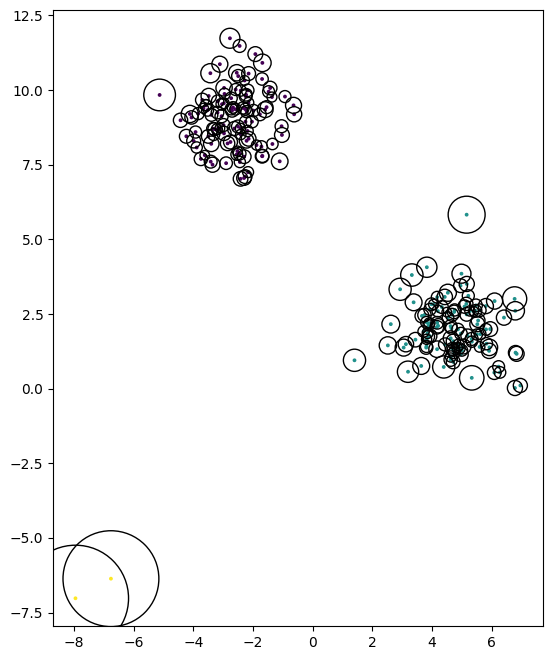

In [ ]:
f, ax = plt.subplots(figsize=(14, 8))
ax.scatter(data[:,0], data[:,1], c=labels, s=3)
ax.set_aspect(1)
for i in range(len(my_lof_scores)):
    ax.add_artist(plt.Circle(tuple(data[i]), my_lof_scores[i] / 5 , fill = False))

# 2. Isolation Forest
Next we will implement the Isolation Forest.

Again, we will use a dataset, which is created below.

In [147]:
rng = np.random.default_rng(seed=42)

# data to build forest on
data = rng.normal(loc=[2, 5, 2, 5], scale=2, size=[400, 4])
outliers = rng.normal(loc=[2, 0, 2, 0], scale=2, size=[10, 4])

# data to test with
testdata = np.vstack((rng.normal(loc=[2, 5, 2, 5], scale=2, size=[200, 4]), 
                     rng.normal(loc=[2, 0, 2, 0], scale=2, size=[20, 4])))

tainted_data = np.vstack((data, outliers))
print(data.shape, outliers.shape, testdata.shape, tainted_data.shape)



(400, 4) (10, 4) (220, 4) (410, 4)


## Implementing
Below is some skeleton code which is left for you to implement the isolation forest

In [196]:
import random
class iTree:
    def __init__(self, D, e, l):
        """
        constructs an isolation tree given the input parameters:
        
        :D: is the dataset
        :e: is the current path length
        :l: is the maximum path length
        """
        self.right = None
        self.left = None
        if(len(D)==0):
            return None
        #print("dataset: ", D)
        if(e>=l or D.shape[1]<=1):
            return None
        self.features = D.shape[1]
        self.q = random.randint(0, self.features-1)
        self.p = random.uniform(min(D[:,self.q]), max(D[:,self.q]))
        #print(p)
        D_l = [i for i in D if (i[self.q]<self.p)]
        D_r = [i for i in D if (i[self.q]>=self.p)]
        #print(np.array(D_r).shape)
        self.right = iTree(np.array(D_r), e+1, l)
        self.left = iTree(np.array(D_l), e+1, l)
    
    def test(self, o, pl = 0):
        """
        test the datapoint :o: against this tree, returns the path length
        """
        if self.left is None and self.right is None:
            return pl + 1
        
        if o[self.q] < self.p:
            return self.left.test(o, pl + 1)
        else:
            return self.right.test(o, pl + 1)
        


In [242]:
class iForest:
    def __init__(self, D, t, phi):
        """
        Constructs an Isolation Forest given the input parameters:
        
        :D: the dataset
        :t: number of isolation trees
        :phi: size of subset to take from D
        """
        self.D = D
        self.t = t
        self. phi = phi
        #self.features = D.shape[1]
        self.forest =[]
        for _ in range(t):
            D_prime = np.array(random.choices(D, k=phi))
            self.forest.append(iTree(D_prime, 0, np.log2(phi)))
            
            
        
    
    def test(self, o):
        """
        Tests the given datapoint :o: on the isolation trees and returns the average path length.
        For getting a score, I implemented the formula from the slides in function Score. 
        """
        
        self.avg_pl = 0
        for i in range(self.t):
            tree = self.forest[i]
            tree.e = tree.test(o)
            self.avg_pl+=tree.e
        return self.avg_pl/self.t
        

## Tainted vs. Untainted Datasets
- Build the isolation forest on both the untainted and the tainted dataset (for the tainted dataset just combine the data and outliers, don't use the test data)
- Plot the ROC curves for both isolation forests. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html for a function to calculate the ROC curve. Note that we take anomalies as the positive class.
1. Does it significantly affect the performance of the isolation forest? Shortly explain why it does or it doesn't.
2. A nice property of the isolation forest is that we can use subsampling without degradation in performance. How does subsampling help with masking?

## Answer
- Write your answers here

### Plotting the AUC for both models and showing those

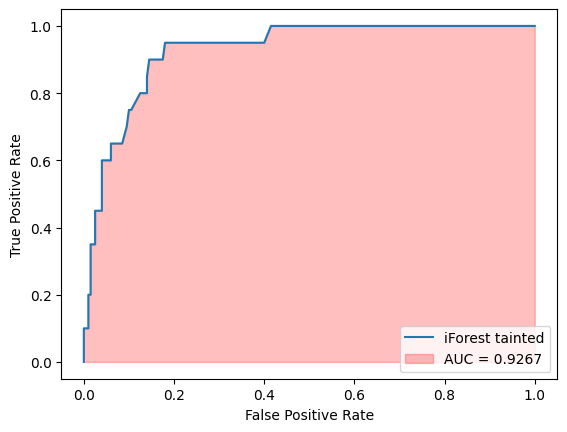

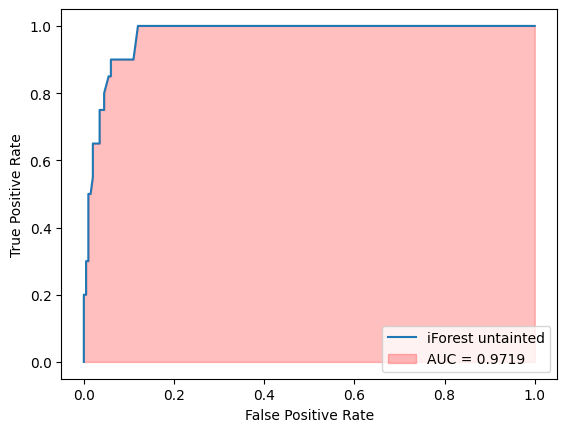

In [243]:

def Score(iforest, x):
    iforest.test(x)
    not_pl = sum(iforest.forest[i].e for i in range(iforest.t))
    c = 2*(np.log(iforest.phi-1)+0.5772156649) - (2*(iforest.phi-1)/iforest.phi)
    return 2**(-not_pl/c)
    
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import random
random_phi = random.randint(2, data.shape[0])
forest_tainted = iForest(tainted_data, 100, random_phi)
forest_untainted = iForest(data, 100, random_phi)
predictions = []
y_true = np.array([0]*200 + [1]*20)
for data_point in testdata:
    predictions.append(Score(forest_tainted, data_point))


fpr, tpr, _ = roc_curve(y_true,  predictions)
#print(predictions)

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='iForest tainted')
roc_display.plot()
auc_roc = auc(fpr, tpr)
plt.fill_between(fpr, tpr, alpha=0.25, color='r', label='AUC = %0.4f' % auc_roc)
plt.legend()
plt.show()



predictions = []
for data_point in testdata:
    predictions.append(Score(forest_untainted, data_point))

fpr, tpr, _ = roc_curve(y_true,  predictions)
auc_roc = auc(fpr, tpr)

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='iForest untainted')
roc_display.plot()
plt.fill_between(fpr, tpr, alpha=0.25, color='r', label='AUC = %0.4f' % auc_roc)
plt.legend()
plt.show()



## Task: Understanding the hyperparameters
3. Play around with the hyperparameters. How small / large can you subsample before your performance starts to decrease? Why? How many trees do you need in the forest?

## Answer
- Write your answers here

## Task: Building a detector
We now have an isolation forest which can give a measure of anomalousness for a given datapoint. But how are we going to use it to detect anomalies?

4. Using a threshold, create a detector which given a datapoint indicates whether it is anomalous or not. It should return a 1 if it is an anomaly, and a 0 if it is normal data.
    - NOTE: Motivate why you choose your threshold using metrics
    
## Answer
- Write your answers here

In [ ]:
def detect(datapoint, threshold):
    """
    Returns 1 if the given datapoint is an anomaly, 0 otherwise.
    """
    predictions = []
    for data_point in testdata:
        predictions.append(forest_untainted.test(data_point))

        fpr, tpr, threashold = roc_curve(y_true,  predictions)
        if(fpr[datapoint] > threshold):
            return 1
        else:
            return 0
    

## Task: Evaluate
Now we want to evaluate the performance of your detector.
- Calculate the True Positive Rate, False Positive Rate, and Precision for your detector based on the output of the confusion matrix. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix for how to use the function, and see https://en.wikipedia.org/wiki/Confusion_matrix for how to calculate the metrics.
   - NOTE: do NOT use some other convenience function from sklearn or elsewhere to calculate these metrics. These may only be used to validate your metrics.

5. Are you happy with the performance of the model? Why or why not?

## Answer
- Write your answers here

In [ ]:
from sklearn.metrics import confusion_matrix

# 3. Machine Learning for Temporal Anomaly Detection
We will now look at the case of temporal data. For temporal data, it is possible to use any conventional Machine Learning model in order to perform anomaly detection. We start by creating a simple dataset below. We inject an anomaly towards the end of the dataset which will be included in the test dataset.

(1000,)


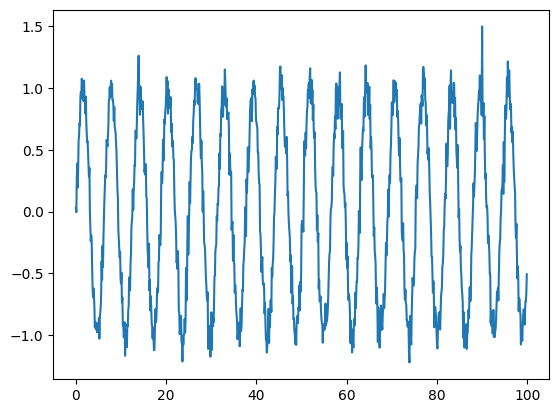

In [386]:
rng = np.random.default_rng(seed=42)
y = np.sin(np.arange(0, 100, 0.1)) + rng.normal(loc=0, scale=0.1, size=1000) ## 1000 points
y[900] = 1.5 # outlier
train = y[:800] # 80% of the data
test = y[800:]  # 20% of the data
plt.plot(np.arange(0, 100, 0.1), y)
print(y.shape)
#print(train)

## Question
I have created this simple dataset by using a sine function and adding some gaussian-distributed noise. 
1. Is this training dataset tainted or untainted? Explain why or why not.

## Answer
- Write your answers here

## Task: Set up the training
We will use a ML algorithm with a sliding window to try and predict the next value based on the last 24.
- transform the train and test datasets into appropriate shapes to train the model
- the model should take the last 24 datapoints (X) to predict the next datapoint (Y)

In [312]:
indices = [i for i in range(0, len(train), 24)]
print(indices)
print(train.shape)
train_x = np.array([train[indices[i]:indices[i+1]] for i in range(len(indices)-1)])

print(train_x.shape)
train_y = train[24::24]

print(train_y.shape)
indices = [i for i in range(0, len(test), 24)]
test_x = np.array([test[indices[i]:indices[i+1]] for i in range(len(indices)-1)] )
test_y = test[24::24]


#print("first 24 elements train x ", train_x[:24])
#print("prediction 0 ", train_y[0])
#print("original dataset train ", train[24])
#print(train_x[24:48])
#print(train_y[1])
#print(train[48])
#plt.plot(, train_x) """
print(test_x.shape)
print(test_y.shape)
print(test.shape)


[0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648, 672, 696, 720, 744, 768, 792]
(800,)
(33, 24)
(33,)
(8, 24)
(8,)
(200,)


## Task: Train the model
Now that we have the datasets set up properly, we can train our model. Let's use a random forest regressor. 
- Train the random forest regressor on the train dataset
- Use the trained random forest regressor to make predictions on the test dataset

In [317]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score
model = RandomForestRegressor(random_state=0)

model.fit(train_x, train_y)
print(model.predict(test_x)-test_y)

print(explained_variance_score(test_y, model.predict(test_x)))
print(r2_score(test_y, model.predict(test_x)))


[-0.16182214  0.15405657 -0.26885514 -0.00650951  0.17877592 -0.30977856
 -0.0670852  -0.16324358]
0.9285982357831444
0.9124391416342476


## Task: Plot your predictions
Let's see visually how the model performs. 
- Plot the predictions of your model against the actual values.
2. Does your model perform well?
3. Do you think it matters for this set-up if the training dataset is tainted or untainted? Why?

## Answer
- Write your answers here

(8,)
(9,)


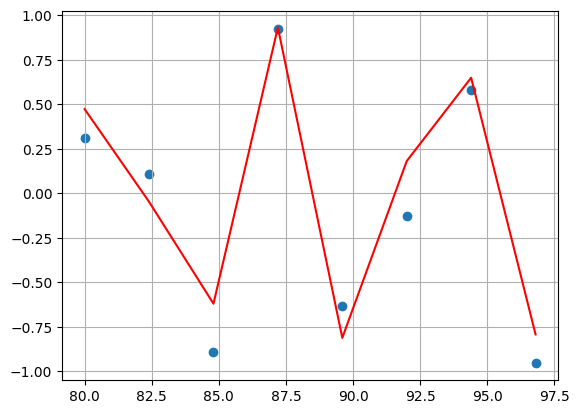

In [337]:
print(model.predict(test_x).shape)
print(np.arange(0, 100, 0.1)[800::24].shape)
plt.scatter(np.arange(0, 100, 0.1)[800:-25:24], model.predict(test_x))
plt.plot(np.arange(0, 100, 0.1)[800:-25:24], test_y, color='r')
plt.grid()
plt.show()

## Task: plot the prediction residual. 
To actually detect the anomalies, we need to calculate the residual. 
- Calculate the residual and plot it.
4. Does the residual look useful for detecting anomalies?
- Check if the injected anomaly can be detected using your residual score without giving any false positives

## Answer
- Write your answers here

(8,)
(9,)


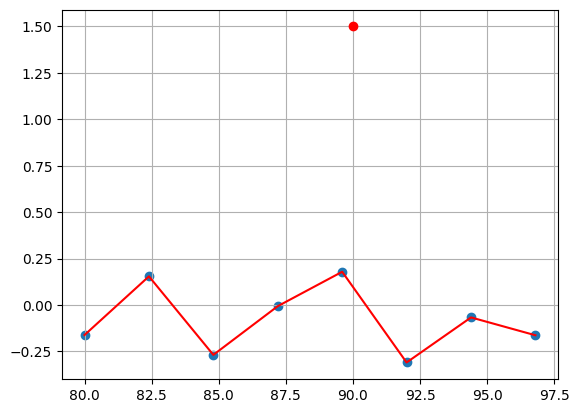

In [346]:
print(model.predict(test_x).shape)

print(np.arange(0, 100, 0.1)[800::24].shape)
plt.scatter(np.arange(0, 100, 0.1)[800:-25:24], model.predict(test_x) - test_y)
plt.plot(np.arange(0, 100, 0.1)[800:-25:24], model.predict(test_x) - test_y, color='r')
plt.plot([90], y[900], 'ro')
#plt.plot([90], model.predict(test_x[])-y[900], 'bo')
plt.grid()
plt.show()

# 4. Autoencoder for Anomaly Detection
Lastly, we will use an autoencoder on the same temporal dataset to detect anomalies. Although we will use it now in a temporal setting, note that autoencoders can also be used to detect anomalies in non-temporal data.

In [564]:
import torch
torch.device("mps")

device(type='mps')

## Task: Create train / test dataset
We will use the autoencoder slightly differently. Let's pretend that this dataset is the temperature at our nuclear reactor. We take a measurement every hour and we upload this data once per day to our server, at which point we use the autoencoder to detect anomalies.
- transform the train and test datasets into appropriate shapes to train the model
- the model should take a window of 24 datapoints and reconstruct it. The stride should be 24.

In [565]:
#train_x = np.array([train[i:i+24] for i in range(len(train))])

train_x = np.array([train[i:i+24] for i in range(0, len(train), 24)][:-8])
print(train_x.shape)
print(test.shape)
train_x = torch.from_numpy(train_x).float().to("mps")
test_x = np.array([test[j:j+24] for j in range(0, len(test), 24)][:-1])
print(test_x.shape)
test_x = torch.from_numpy(test_x).float().to("mps")

(26, 24)
(200,)
(8, 24)


## Task: Train the autoencoder
Below I have provided a simple autoencoder class which you can use.
- Use the MSE loss and the Adam optimizer to train an autoencoder on the training dataset you created.

In [566]:
class Autoencoder(torch.nn.Module):
    def __init__(self, latent_nodes):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(24, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, latent_nodes)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_nodes, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 24)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [567]:
model = Autoencoder(1).to("mps")

loss_fn = torch.nn.MSELoss().to("mps")
optimizer = torch.optim.Adam(model.parameters())


In [568]:
# TODO: training loop
def training_epoch(model, train_x, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.
    losses=[]
    iterations=0
    for i, data in enumerate(train_x):
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, data)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        iterations+=1
        if i % 30 == 0:
            last_loss = running_loss / 30 # loss per batch
            print(f'batch {i + 1} loss: {last_loss}')
            running_loss = 0.
    
    return last_loss, losses, iterations

batch 1 loss: 0.022338724136352538
Epoch 0 loss: 0.022338724136352538
batch 1 loss: 0.021385324001312257
Epoch 1 loss: 0.021385324001312257
batch 1 loss: 0.021021356185277302
Epoch 2 loss: 0.021021356185277302
batch 1 loss: 0.020713992913564048
Epoch 3 loss: 0.020713992913564048
batch 1 loss: 0.020304560661315918
Epoch 4 loss: 0.020304560661315918
batch 1 loss: 0.019464407364527384
Epoch 5 loss: 0.019464407364527384
batch 1 loss: 0.018048961957295735
Epoch 6 loss: 0.018048961957295735
batch 1 loss: 0.015884741147359212
Epoch 7 loss: 0.015884741147359212
batch 1 loss: 0.012556520104408265
Epoch 8 loss: 0.012556520104408265
batch 1 loss: 0.009867372115453084
Epoch 9 loss: 0.009867372115453084
batch 1 loss: 0.007274757822354635
Epoch 10 loss: 0.007274757822354635
batch 1 loss: 0.004938581585884094
Epoch 11 loss: 0.004938581585884094
batch 1 loss: 0.003199801594018936
Epoch 12 loss: 0.003199801594018936
batch 1 loss: 0.00205874132613341
Epoch 13 loss: 0.00205874132613341
batch 1 loss: 0.00

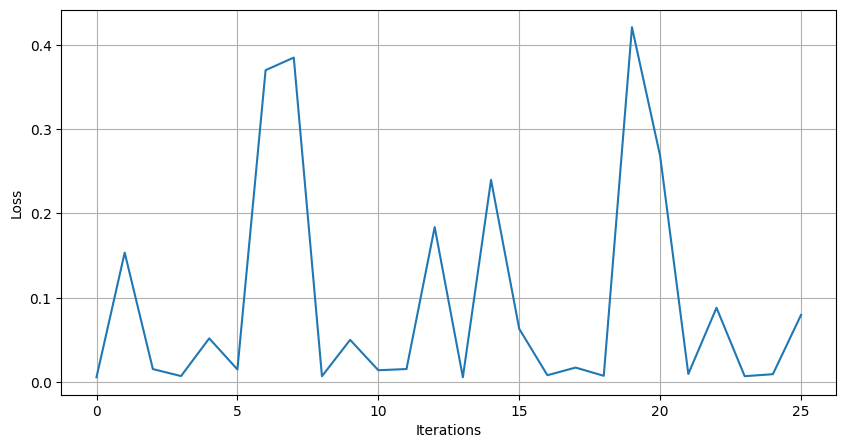

In [569]:
#EPOCHS = 10
epoch=0
avg_loss=10000
losses =[]
iterations=0
while(avg_loss>0.0002):
    model.train(True)
    avg_loss, losses, iterations = training_epoch(model, train_x, optimizer, loss_fn)
    
    print(f'Epoch {epoch} loss: {avg_loss}')
    epoch+=1
model.train(False)
plt.figure(figsize=(10, 5))
plt.plot(list(range(iterations)), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()


<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.19421398569829762
(192,)


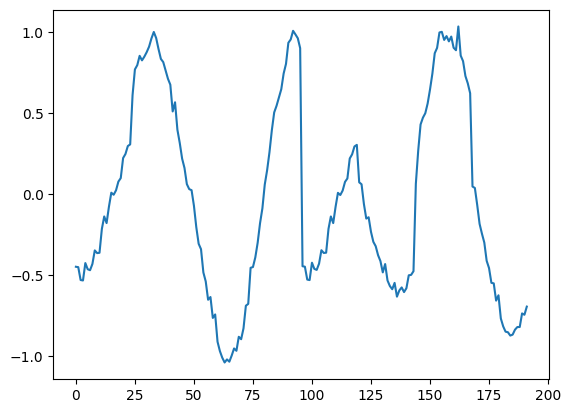

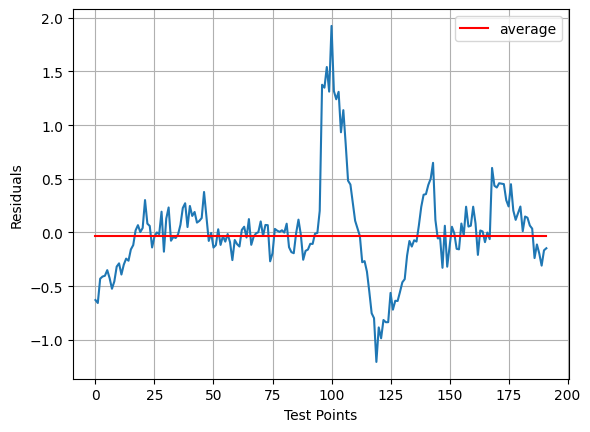

In [570]:
model.eval()
print(type(test))
#print(test_x.shape)
test_loss =0.
recostracted_data = []

with torch.no_grad():
    
    for data in test_x:
        out = model(data)
        recostracted_data.append(torch.Tensor.cpu(out).numpy())
        loss = loss_fn(out, data)
        test_loss += loss.item()
    print("AVG LOSS ", test_loss/len(test_x))
recostracted_data=np.array(recostracted_data).flatten()
print(recostracted_data.shape)
plt.plot(recostracted_data)
plt.grid()
plt.show()
plt.grid()
plt.plot(test[:192]-recostracted_data)
plt.plot(np.full(192, np.average(recostracted_data)),  color='r', label="average")
plt.legend()
plt.xlabel("Test Points")
plt.ylabel("Residuals")
plt.show()


## Task: Plotting
Once you have achieved a loss you are happy with (should be below or around 0.02), apply the autoencoder to the test dataset and plot the reconstructed data.
Next, plot the reconstruction error on the test dataset. 
1. Is the reconstruction error useful to detect the anomaly?
2. Which approach do you prefer for temporal data: to use ML to predict next values, or to use an autoencoder to reconstruct the data? Why?
3. There are a couple of hyperparameters which you had to figure out to train an accurate model (number of nodes in latent space, learning rate, number of epochs). Describe how the number of nodes in the autoencoder affects the performance of the model using plots.

## Answer
- Write your answers here